### evaluate a model by draw prediction visually for a lond horizon



In [14]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from indycar.model.NaivePredictor import NaivePredictor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load Data

In [2]:
import os
os.getcwd()

'/scratch/hpda/indycar/notebook/10.OracleModel'

In [3]:
#
# parameters
#
#year = '2017'
year = '2018'
#event = 'Toronto'
#https://www.racing-reference.info/season-stats/2018/O/#
events_totalmiles=[256,500,372,268,500,310]
events_laplen = [1.022,2.5,1.5,0.894,2.5,1.25]
events = ['Phoenix','Indy500','Texas','Iowa','Pocono','Gateway']
#events = ['Gateway']

#events = ['Indy500']
#events = ['Phoenix']
events_id={key:idx for idx, key in enumerate(events)}

In [4]:
import pickle
with open('telemetry-oracle-%s.pickle'%year, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, telemetry_data = pickle.load(f, encoding='latin1')    

In [5]:
#test telemetry
datalist = telemetry_data[0][2]
len(datalist)

23

### convert to gluonts dataset

In [6]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
teleCols = ['seqid','distance', 'vspeed', 'rpm', 'gear', 
                 'brake', 'throttle', 'steering','track_status','lap_status']
teleColId={key:idx for idx, key in enumerate(teleCols)}

COL_DISTANCE=1
COL_VSPEED=2
COL_TRACKSTATUS=8
COL_LAPSTATUS=9

MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TEST = 4
MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

def make_dataset(runs, prediction_length, freq, 
                       run_ts=COL_VSPEED, #teleColId['vspeed'], 
                       train_ratio = 0.8,
                       use_global_dict = True,
                       oracle_mode = MODE_ORACLE,
                       interpolate = True,
                       nan_threshold=0.1, test_cars = []
                ):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

    train_set = []
    test_set = []
    
    #select run
    if runs>=0:
        _telemetry_data = [telemetry_data[runs].copy()]
    else:
        _telemetry_data = telemetry_data.copy()
    
   
    #_data: eventid, carids, datalist[carnumbers, features, tslen]->
    #[laptime, rank, track, lap]]
    #telemetry dataset <eventid, carids, ts[carid][second_seqid, vspeed, distance...])>; filled with NaN
    for _data in _telemetry_data:
        _train = []
        _test = []
        
        #statistics on the ts length
        ts_len = [ _entry.shape[0] for _entry in _data[2]]
        train_len = int(np.max(ts_len) * train_ratio)
        
        print(f'====event:{events[_data[0]]}, train_len={train_len}, max_len={np.max(ts_len)}, min_len={np.min(ts_len)}')
                
        # process for each ts
        for rowid in range(len(_data[2])):
            # teleColId['vspeed']
            # rec:= [ts_seqid, distance, vspeed...]
            rec = _data[2][rowid].copy()
            
            ##remove all nan
            #rec = rec[~np.isnan(rec)]
            # remove nan at tail
            idx = 1
            while idx < rec.shape[0]:
                nan_count = np.sum(np.isnan(rec[idx]))
                #if rec[-idx,0] == np.nan or rec[-idx,1] == np.nan or rec[-idx,2] == np.nan:
                if nan_count > 0:
                    idx += 1
                    continue
                break
            if idx > 1:
                rec = rec[:-idx]
            
            # remove short ts
            totallen = rec.shape[0]
            if ( totallen < train_len + prediction_length):
                print(f'a short ts: carid={_data[1][rowid]}，len={totallen}, nancnt={nan_count}')
                continue
                
            # nan interpolate
            _checker = rec[:, run_ts]
            nans, x= nan_helper(_checker)
            nan_count = np.sum(nans) 
            if nan_count > 0 and interpolate:
                rec[nans,run_ts]= np.interp(x(nans), x(~nans), _checker[~nans])
            
            if nan_count > nan_threshold * totallen:
                #skip this ts, if there too many nans
                print(f'carno:{_data[1][rowid]}, totallen:{totallen}, nancount:{nan_count}, skip')
                continue            

            ip_cols=[COL_TRACKSTATUS,COL_LAPSTATUS]
            for col in ip_cols:
                _checker = rec[:, col]
                nans, x= nan_helper(_checker)
                nan_count = np.sum(nans) 
                if nan_count > 0:
                    if interpolate:
                        rec[nans,col]= np.interp(x(nans), x(~nans), _checker[~nans])
                    else:
                        #force to clear
                        rec[nans,col]= 0
                
            if use_global_dict:
                carno = _data[1][rowid]
                carid = global_carids[_data[1][rowid]]
            else:
                #simulation dataset, todo, fix the carids as decoder
                carno = rowid
                carid = rowid
                
            #eval on carids
            if carno not in test_cars:
                continue
                
            # tranpose [features, ts]
            rec = rec.T
                
            # selection of features
            if test_flag(oracle_mode, MODE_NOTRACK):                
                rec[COL_TRACKSTATUS, :] = 0
            if test_flag(oracle_mode, MODE_NOLAP):                
                rec[COL_LAPSTATUS, :] = 0
                
            # split and add to dataset record
            _train.append({'target': rec[run_ts,:train_len].astype(np.float32), 
                            'start': start, 
                            'feat_static_cat': [carid],
                            'feat_dynamic_real': [rec[COL_TRACKSTATUS,:train_len],
                                   rec[COL_LAPSTATUS,:train_len]]
                          }
                          )
            
            # multiple test ts(rolling window as half of the prediction_length)
            test_rec_cnt = 0
            for endpos in range(totallen, train_len+prediction_length, 
                                -int(prediction_length/2)):
                
                track_rec = rec[COL_TRACKSTATUS, :endpos].copy()
                lap_rec = rec[COL_LAPSTATUS, :endpos].copy()
                
                # test mode
                if test_flag(oracle_mode, MODE_TEST):
                    #set prediction part as nan
                    #track_rec[-prediction_length:] = np.nan
                    #lap_rec[-prediction_length:] = np.nan
                    
                    # since nan does not work, use cur-val instead
                    track_rec[-prediction_length:] = track_rec[-prediction_length - 1]
                    #track_rec[-prediction_length:] = random.randint(0,1)
                    #lap_rec[-prediction_length:] = lap_rec[-prediction_length - 1]
                    lap_rec[-prediction_length:] = 0
                    
                
                _test.append({'target': rec[run_ts,:endpos].astype(np.float32), 
                            'start': start, 
                            'feat_static_cat': [carid],
                            'feat_dynamic_real': [track_rec,lap_rec]
                            #'feat_dynamic_real': [rec[COL_TRACKSTATUS,:endpos],
                            #       rec[COL_LAPSTATUS,:endpos]] 
                             }
                          )   
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'train len:{len(train_set)}, test len:{len(test_set)}')
    
    train_ds = ListDataset(train_set, freq=freq)
    test_ds = ListDataset(test_set, freq=freq)    
    
    return train_ds, test_ds, train_set, test_set

def save_dataset(datafile,freq, prediction_length, cardinality, train_ds, test_ds):
    with open(save_prefix + datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [7]:
def make_gluontsdb(eventid):
    #run on indy dataset
    train_ds, test_ds,_,_ = make_dataset(eventid, prediction_length,freq,
                                         interpolate=interpolate, test_cars=test_cars)
    save_dataset(f'vspeed-oracle{ipstr}-f{freq}-t{prediction_length}-gluonts-indy-2018.pickle'
                 , freq, prediction_length, cardinality,train_ds, test_ds)
    train_ds, test_ds,_,_ = make_dataset(eventid, prediction_length,freq, oracle_mode=MODE_NOTRACK,
                                         interpolate=interpolate,test_cars=test_cars)
    save_dataset(f'vspeed-oracle{ipstr}-notrack-f{freq}-t{prediction_length}-gluonts-indy-2018.pickle'
                 , freq, prediction_length, cardinality,train_ds, test_ds)
    train_ds, test_ds,_,_ = make_dataset(eventid, prediction_length,freq, oracle_mode=MODE_NOLAP,
                                         interpolate=interpolate,test_cars=test_cars)
    save_dataset(f'vspeed-oracle{ipstr}-nolap-f{freq}-t{prediction_length}-gluonts-indy-2018.pickle'
                 , freq, prediction_length, cardinality,train_ds, test_ds)
    train_ds, test_ds,_,_ = make_dataset(eventid, prediction_length,freq, oracle_mode=MODE_TEST,
                                         interpolate=interpolate,test_cars=test_cars)
    save_dataset(f'vspeed-oracle{ipstr}-testcurtrack-f{freq}-t{prediction_length}-gluonts-indy-2018.pickle'
                 , freq, prediction_length, cardinality,train_ds, test_ds)
    train_ds, test_ds,_,_ = make_dataset(eventid, prediction_length,freq, oracle_mode=MODE_TEST + MODE_NOLAP
                                         ,interpolate=interpolate,test_cars=test_cars)
    save_dataset(f'vspeed-oracle{ipstr}-nolapcurtrack-f{freq}-t{prediction_length}-gluonts-indy-2018.pickle'
                 , freq, prediction_length, cardinality,train_ds, test_ds)

#### evaluate

In [8]:
def plot_prob_forecasts(ts_entry, forecast_entry, outputfile):

    plot_length = context_length 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)

    #fig, axs = plt.subplots(figcnt, 1, figsize=(10, 7))

    #for idx in range(figcnt):

    #    ts_entry[idx][-plot_length:].plot(ax=axs[idx])  # plot the time series
    #    forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
    #    axs[idx].grid(which="both")
    #    axs[idx].legend(legend, loc="upper left")
    
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(10, 7))
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs)  # plot the time series
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.savefig(outputfile + '-%d.pdf'%idx)
        plt.show()

def evaluate_model(predictor, evaluator, test_ds, outputfile):
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    
    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    #convert to univariate format
    # tss: <ts_len, #feature>
    # forecasts.sample: < 100, prediction_length, #feature>
   
    #tss_n = []
    #for ts in tss:
    #    tse = ts.to_numpy()
    #    tss_n.append(tse[:,0].reshape((tse.shape[0])))
    #cast_n = []
    #for fc in forecasts:
    #    nfc = fc
    #    fcs = fc.samples.shape
    #    nsamples = fc.samples[:,:,0].reshape((fcs[0], fcs[1]))
    #    nfc.samples = nsamples
    #    cast_n.append(nfc)
    #tss = tss_n
    #forecasts = cast_n


    # car12@rank1, car1@rank16, car7@rank33, the index is 7,0,4 accordingly
    # Indy500 Car 12 WillPower
    #offset = 52-7
    offset = 0
    ts_entry = [tss[7+offset],tss[0+offset],tss[4+offset]]
    forecast_entry = [forecasts[7+offset],forecasts[0+offset],forecasts[4+offset]]

    #debug
    #print(f'ts_entry shape:{ts_entry[0].shape}, forecast:{forecast_entry[0].samples.shape}')

    plot_prob_forecasts(ts_entry, forecast_entry, outputfile)
    
    #evaluator = MultivariateEvaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    
    
    print(json.dumps(agg_metrics, indent=4))
        

In [11]:
# construct long prediction result
def plot_prob_forecasts_ex(ts_entry, forecast_entry, outputfile):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(20, 7))
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.savefig(outputfile + '-%d.pdf'%idx)
        plt.show()
        


def long_predict(output):
    
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print(first_start, last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    newsamples = np.zeros((2*nsample, last_start - first_start + npredict))

    blockid = 0
    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start
        #copy sample to block
        newsamples[nsample*blockid: nsample*blockid + nsample, pos:pos + npredict] = forecasts[idx].samples

        blockid = (blockid + 1) % 2

    #first block
    newsamples[nsample*blockid: nsample*blockid + nsample, 0:0 + npredict] = forecasts[-1].samples

    #last block
    blockid = 1
    newsamples[nsample*blockid: nsample*blockid + nsample, last_start- first_start:last_start- first_start + npredict] = forecasts[0].samples

    target.samples = newsamples

    plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target

### evaluate

In [12]:
cardinality = [len(global_carids)]
test_cars = [12]
test_event = 'Indy500'
save_prefix = 'test-' + test_event + '_'.join([str(x) for x in test_cars])
outputfile = 'output'

#model configure
interpolate = False
ipstr = '' if interpolate else '-noip'
prediction_length = 10
context_length = 20
freq = "1min"

train_ds, test_ds,_,_ = make_dataset(events_id[test_event], prediction_length,freq, oracle_mode=MODE_NOLAP,
                                         interpolate=interpolate,test_cars=test_cars)


====event:Indy500, train_len=8659, max_len=10824, min_len=1969
a short ts: carid=3，len=7918, nancnt=0
a short ts: carid=10，len=2868, nancnt=0
carno:12, totallen:10782, nancount:85, test_reccnt:423
a short ts: carid=13，len=3557, nancnt=0
a short ts: carid=18，len=6851, nancnt=0
a short ts: carid=24，len=8246, nancnt=0
a short ts: carid=30，len=1969, nancnt=0
a short ts: carid=32，len=6069, nancnt=0
a short ts: carid=33，len=2394, nancnt=0
train len:1, test len:423


INFO:root:Using GPU


tss len=423, forecasts len=423
8662 10772
sampel# x predictlen:  100 10


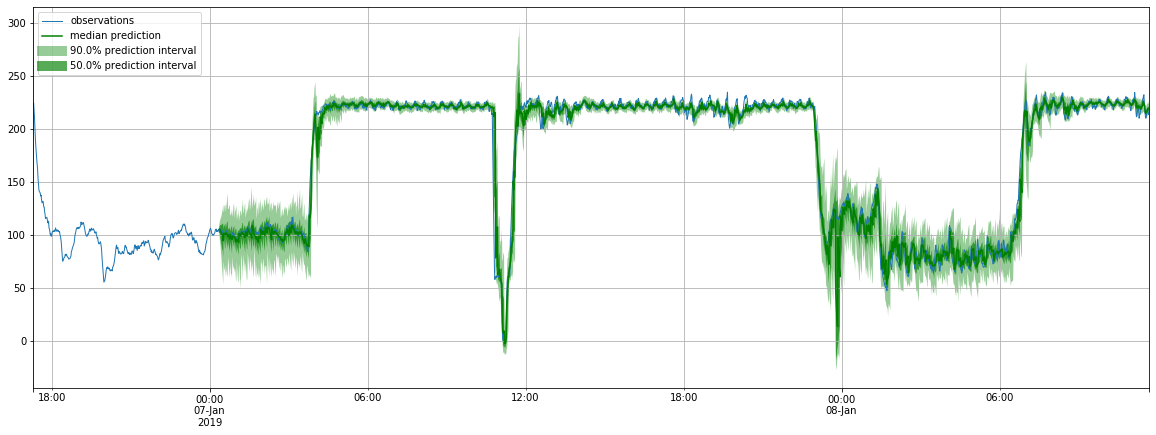

In [15]:
#load predictor
model='deepAR-Oracle-vspeed-nolap-indy-f1min-t10-e1000-r1'
modeldir = '../models/' + model
predictor =  Predictor.deserialize(Path(modeldir))

target = long_predict('deepAR-Oracle-vspeed')

INFO:root:Using GPU


tss len=423, forecasts len=423
8662 10772
sampel# x predictlen:  100 10


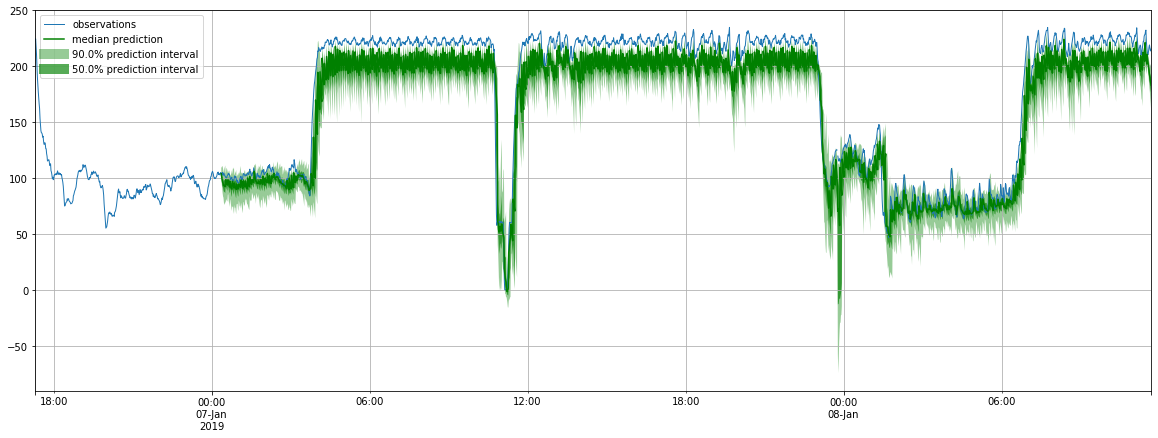

In [96]:
#load predictor
model='deepAR-vspeed-nolap-indy-f1min-t10-e1000-r1'
modeldir = '../models/' + model
predictor =  Predictor.deserialize(Path(modeldir))

target = long_predict('deepAR-vspeed')

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=423, forecasts len=423
8662 10772
sampel# x predictlen:  100 10


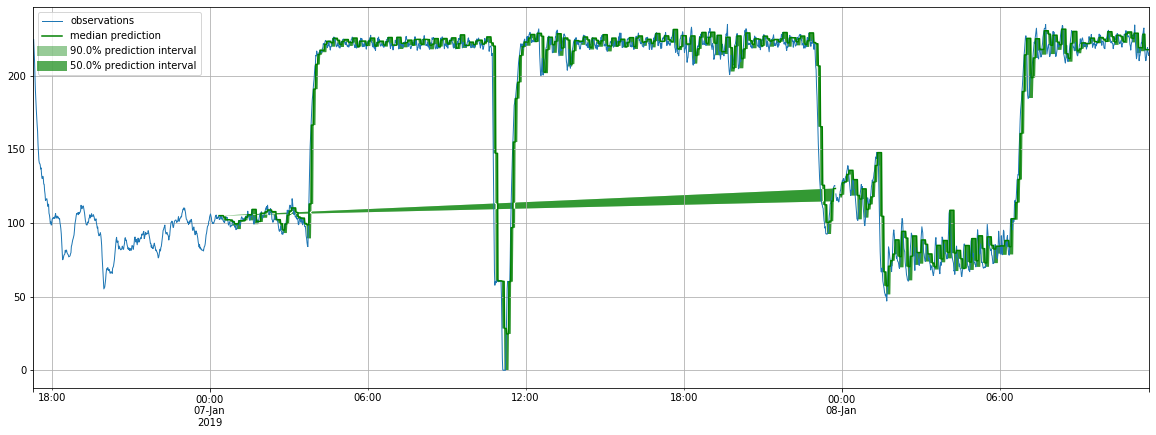

In [17]:
#load predictor
#model='naive-vspeed-nolap-indy-f1min-t10-e1000-r1'
#modeldir = '../models/' + model
#predictor =  Predictor.deserialize(Path(modeldir))
predictor =  NaivePredictor(freq= freq, prediction_length = prediction_length)

target = long_predict('naive-vspeed')

/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

  warnings.warn(x, RRuntimeWarning)
/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/gluonts/model/r_forecast/_predictor.py:191: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  + data["target"].shape[0]


tss len=423, forecasts len=423
8662 10772
sampel# x predictlen:  100 10


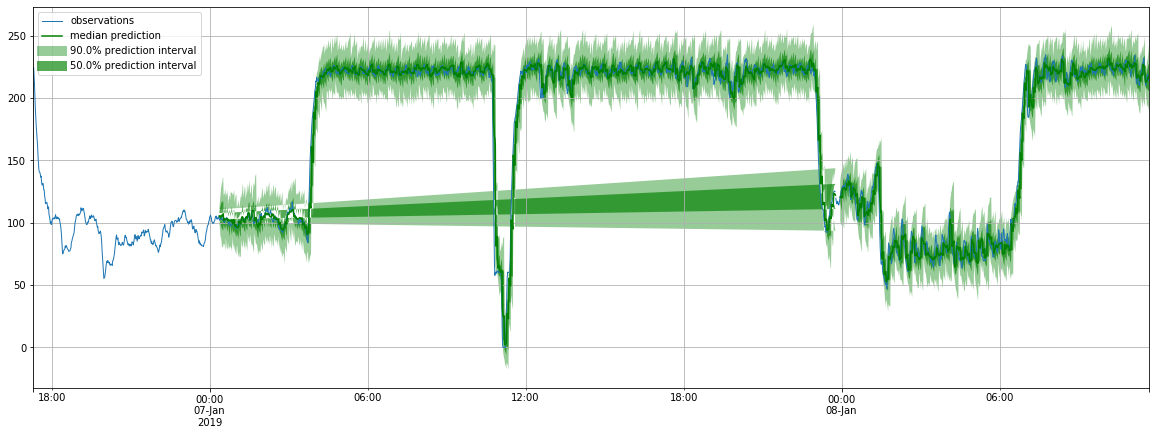

In [18]:
predictor =  RForecastPredictor(method_name='arima',freq= freq, prediction_length = prediction_length)

target = long_predict('naive-vspeed')

### test

In [ ]:
prediction_length = 10
context_length = 20
model='deepAR-Oracle-vspeed-nolap-indy-f1min-t10-e1000-r1'
freq = "1min"

cardinality = [len(global_carids)]
interpolate = False
ipstr = '' if interpolate else '-noip'
test_cars = [12]
test_event = 'Indy500'
save_prefix = 'test-' + test_event + '_'.join([str(x) for x in test_cars])
outputfile = 'output'
#make_gluontsdb(events_id[test_event])

train_ds, test_ds,_,_ = make_dataset(events_id[test_event], prediction_length,freq, oracle_mode=MODE_NOLAP,
                                         interpolate=interpolate,test_cars=test_cars)

#get target dim
entry = next(iter(train_ds))
target_dim = entry['target'].shape
target_dim = target_dim[0] if len(target_dim) > 1 else 1
print('target_dim:%s', target_dim)

In [ ]:
#if target_dim > 1:
#    evaluator = MultivariateEvaluator(quantiles=[0.1, 0.5, 0.9])
#else:
#    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

evaluate_model(predictor, evaluator, test_ds, outputfile)

In [30]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

forecasts = list(forecast_it)
tss = list(ts_it)
print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')

tss len=423, forecasts len=423


In [38]:
tsslen = [len(tss[x]) for x in range(len(tss))]
print(tsslen[-1])
np.mean(tsslen)

8672


9727.0

In [48]:
start_time, row = next(tss[0].iterrows())
start_time

Timestamp('2019-01-01 00:00:00', freq='T')

In [43]:
fstart = [forecasts[x].start_date for x in range(len(forecasts))]

In [ ]:
fstart

In [50]:
td = forecasts[-1].start_date - start_time

In [52]:
td.days*24*60 + td.seconds//60

8662

In [53]:
len(tss[-1])

8672

In [ ]:
forecasts[0]

In [55]:
forecasts[0].samples.shape

(100, 10)

In [56]:
def get_start(idx):
    td = forecasts[idx].start_date - start_time
    return td.days*24*60 + td.seconds//60
    

first_start = get_start(-1)
last_start = get_start(0)
print(first_start, last_start)

8662 10772


In [58]:
import copy
target = copy.deepcopy(forecasts[-1])

In [59]:
target

gluonts.model.forecast.SampleForecast(freq="1min", info=None, item_id=None, samples=numpy.array([[106.02933502197266, 105.1280746459961, 103.90631103515625, 104.23970794677734, 93.28416442871094, 84.24422454833984, 79.37947082519531, 73.23577117919922, 71.67586517333984, 68.90672302246094], [109.03334045410156, 110.58195495605469, 109.75878143310547, 107.13007354736328, 105.27698516845703, 103.41730499267578, 100.2774887084961, 96.71784973144531, 92.12445068359375, 90.7388687133789], [106.49108123779297, 106.63021087646484, 106.07266235351562, 106.14950561523438, 104.89932250976562, 104.82209777832031, 94.07720947265625, 85.23478698730469, 76.16785430908203, 61.64075469970703], [107.05363464355469, 105.74847412109375, 101.61829376220703, 95.6787109375, 91.54714965820312, 89.58674621582031, 84.21968841552734, 79.72257995605469, 77.55341339111328, 78.2406234741211], [105.51221466064453, 104.64061737060547, 105.56880950927734, 108.4459457397461, 106.15650939941406, 101.53194427490234, 99.

In [64]:
#100, 10
nsample, npredict = target.samples.shape
print('sampel# x predictlen: ', nsample, npredict)
newsamples = np.zeros((2*nsample, last_start - first_start + npredict))

blockid = 0
for idx in range(len(forecasts)):
    #copy samples
    start_pos = get_start(idx)
    
    pos = start_pos - first_start
    #copy sample to block
    newsamples[nsample*blockid: nsample*blockid + nsample, pos:pos + npredict] = forecasts[idx].samples
    
    blockid = (blockid + 1) % 2
    
#first block
newsamples[nsample*blockid: nsample*blockid + nsample, 0:0 + npredict] = forecasts[-1].samples

#last block
blockid = 1
newsamples[nsample*blockid: nsample*blockid + nsample, last_start- first_start:last_start- first_start + npredict] = forecasts[0].samples


    

sampel# x predictlen:  100 10


In [66]:
newsamples.shape

(200, 2120)

In [76]:
target.samples = newsamples
target

gluonts.model.forecast.SampleForecast(freq="1min", info=None, item_id=None, samples=numpy.array([[106.02933502197266, 105.1280746459961, 103.90631103515625, 104.23970794677734, 93.28416442871094, 84.24422454833984, 79.37947082519531, 73.23577117919922, 71.67586517333984, 68.90672302246094], [109.03334045410156, 110.58195495605469, 109.75878143310547, 107.13007354736328, 105.27698516845703, 103.41730499267578, 100.2774887084961, 96.71784973144531, 92.12445068359375, 90.7388687133789], [106.49108123779297, 106.63021087646484, 106.07266235351562, 106.14950561523438, 104.89932250976562, 104.82209777832031, 94.07720947265625, 85.23478698730469, 76.16785430908203, 61.64075469970703], [107.05363464355469, 105.74847412109375, 101.61829376220703, 95.6787109375, 91.54714965820312, 89.58674621582031, 84.21968841552734, 79.72257995605469, 77.55341339111328, 78.2406234741211], [105.51221466064453, 104.64061737060547, 105.56880950927734, 108.4459457397461, 106.15650939941406, 101.53194427490234, 99.

In [77]:
target.samples.shape

(200, 2120)

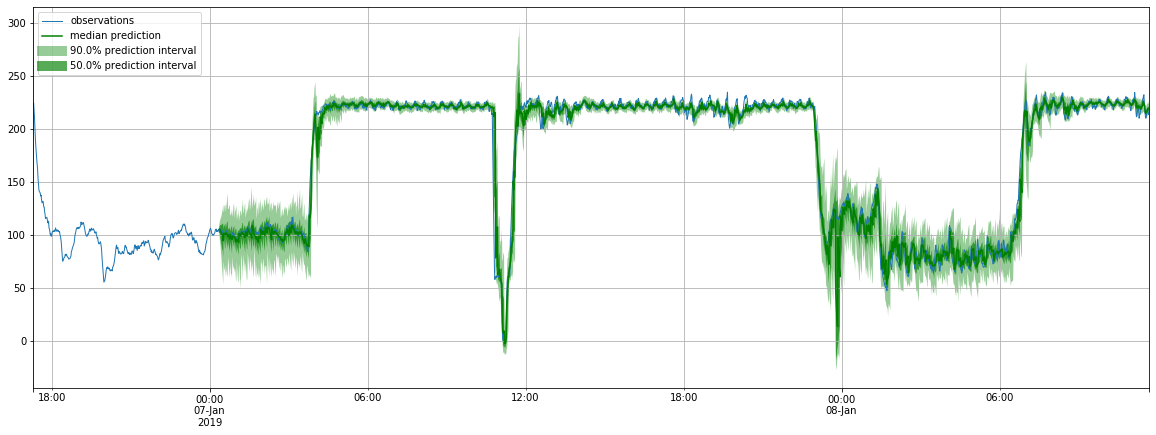

In [92]:
context_length = 0
plot_prob_forecasts_ex([tss[0]],[target],'output')